In [2]:
import csv
import matplotlib.pyplot as plt
from operator import itemgetter, attrgetter
import pandas as pd
import seaborn as sn
import math
import scipy.spatial as spatial
import scipy.stats as stats
import numpy as np
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import functools
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
#Constants
INTERESTING_PATHS = [
    '../sashas-scripts/manyAct_steps/',
    '../sasha-tacas-scripts/tacasHandcraftedModels/',
    '../sasha-tacas-scripts/tacasRealModels/',
    '../sasha-tacas-scripts/tacasRealModels_2/',
    '../sasha-tacas-scripts/tacasRealModels_3/',
    '../sasha-tacas-scripts/tacasRandomConnected/',
    '../sasha-tacas-scripts/oviGood/',
    '../sasha-tacas-scripts/oviBad/',
]
PATH_TO_CSV_FOLDER = INTERESTING_PATHS[3]
print("Chosen Path: "+PATH_TO_CSV_FOLDER)

Chosen Path: ../sasha-tacas-scripts/tacasRealModels_2/


## Load Data

In [4]:
# ================ ONLY RUN THIS IF YOU WANT TO RESET YOUR DATA SET

table_properties = []
table_rows = []

total_rows = 0

filter_dict = dict()
filter_dict["Unknown<=%d" % unknown_threshold] = 0 #Not an interesting model
filter_dict["Timeout"] = 0
filter_dict["SpecialFilters"] = 0


# Values, iters and other csv
table_times = []
excluded_times = []

conf_filter_dict = dict()
conf_filter_dict["NooneHasSolved"] = 0


not_solved = dict()

table_iters = []
excluded_iters = []


table_values = []
excluded_values = []

table_ovi_iters = []
excluded_ovi_iters = []

NameError: name 'unknown_threshold' is not defined

In [5]:
property_meta_keys = ["Model"]

property_keys = [
    "NumStates",
    "NumActions",
    "NumTargets",
    "NumSinks",
    "NumUnknown",
    "NumMaxActions",
    "NumMaxTransitions",
    "SmallestTransProb",
    "NumProbActions",
    "NumMECs",
    "BiggestMEC",
    "SmallestMEC",
    "AvgMEC",
    "MedianMEC",
    "NumSCCs",
    "BiggestSCC",
    "AvgSCC",
    "NearestTarget",
    "FurthestTarget",
    "AvgNumActionsPerState",
    "AvgNumTransPerState",
    "AvgNumTransPerAction",
    "NumMaxStates",
    "NumMinStates",
    "NumBackwardsTransitions"
]

analysis_keys = property_meta_keys + property_keys

In [6]:
metaKeys = ["Model", "#States"]

tacas_keys = [
    "BVI",
    #"D_BVI",
    #"D_SVI",
    "DG_BVI",
    "DG_SVI",
    "G_BVI",
    "G_OVI",
    "G_SVI",
    "OPT_OVI",
    "OVI",
    "SVI",
    "TOP_BVI",
    "TOP_OVI",
    "TOP_SVI",
    "TOP_VI",
    "T_BVI",
    "T_OVI",
    #"T_SVI",
    "VI",
    #"WP",
]

si_keys = [
    "SI",
    "SI_SI",
    "LP_SI",
    "T_SI_SI",
    "T_LP_SI"
]

reduced_config_keys = [
    "OVI",
    "BVI",
    "SVI"
]

big_7 = [
    "VI",
    "BVI",
    "OVI",
    "SVI",
    "WP",
    "TOP_BVI",
    "T_SI_SI",
    #"T_SVI",
    #"T_OVI",
    #"T_BVI",
    #"SI_SI",
    #"T_LP_SI"
]

config_keys = tacas_keys + si_keys
#config_keys = reduced_config_keys
config_keys = big_7

relevantKeys = metaKeys + config_keys
relevantKeys

['Model', '#States', 'VI', 'BVI', 'OVI', 'SVI', 'WP', 'TOP_BVI', 'T_SI_SI']

In [7]:


unknown_threshold = 5
def is_float(entry):
    try:
        float_entry = float(entry)
        return True
    except ValueError:
        return False
    
def is_property_defined(prop, keys, row):
    return (prop in keys and
            is_float(row[prop]))

def should_remove_model(row_to_include, analysis_keys, filter_dict):
    GENERAL_FILTERS = True
    if (GENERAL_FILTERS and not is_property_defined("NumStates", analysis_keys, row_to_include)):
        filter_dict["Timeout"] +=1
        #print("Noone has solved Model %s" % row["Model"])
        return True
    elif (GENERAL_FILTERS and is_property_defined("NumUnknown", analysis_keys, row) and int(row_to_include["NumUnknown"]) <= unknown_threshold):
        filter_dict["Unknown<=%d" % unknown_threshold] +=1
        #print("Model %s has less than %d unknown states --> too easy " % (row["Model"], unknown_threshold))
        return True
    
    #Special Filtering Criteria for different test-suites
    SPECIAL_FILTERS = True
    if (SPECIAL_FILTERS):
        filter_conditions = [
            "hm_25" in row_to_include["Model"],
            #"10000" in row_to_include["Model"],
            #"20000" in row_to_include["Model"],
            #"50000" in row_to_include["Model"],
            #"5000" in row_to_include["Model"],
        
            row_to_include["NumMaxActions"] == 0,
            
            #is_float(row_to_include["NearestTarget"]) and int(row_to_include["NearestTarget"]) > 5,
            #is_float(row_to_include["NumMaxTransitions"]) and int(row_to_include["NumMaxTransitions"]) < 10,
            #is_float(row_to_include["NumMECs"]) and int(row_to_include["NumMECs"]) != 0,
            #int(row_to_include["NumStates"]) < 1000,
            #not "MinAct_10" in row_to_include["Model"],
            #"MinTransProb_0.0001" not in row_to_include["Model"],
            #"Type-tree" in row_to_include["Model"]
        ]
        
        if (True in filter_conditions):
            filter_dict["SpecialFilters"]+=1
            return True
        
        
    return False

def normalization(row, analysis_keys):
    if (is_property_defined("NumStates", analysis_keys, row)):
        for value_to_normalize in [
            "NumTargets",
            "NumSinks",
            "NumUnknown",
        ]:
            if (value_to_normalize in analysis_keys and float(row["NumStates"] != 0)):
                row[value_to_normalize] = float(row[value_to_normalize]) / float(row["NumStates"]) 

with open(PATH_TO_CSV_FOLDER+'analysis.csv', newline='\n') as propertiesFile:
        reader = csv.DictReader(propertiesFile)
        for row in reader:
            total_rows += 1
            row_to_include = {k:row[k] for k in analysis_keys if k in row}
            
            
            
            for key in analysis_keys:
                if (not is_float(row_to_include[key]) and key != "Model"):
                    row_to_include[key] = 0

            #Filtering
            if (should_remove_model(row_to_include, analysis_keys, filter_dict)):
                continue

            #Normalizations
            normalization(row_to_include, analysis_keys)

            table_properties.append(row_to_include)

print("With filtering there are %d/%d models left to check from" % (len(table_properties), total_rows))
print("The rest was filtered because of following reasons: ")
print(filter_dict)

KeyError: 'Unknown<=5'

In [8]:
#print(*list(map(lambda x : (x["Model"]), table_properties)), sep= "\n")
#print(table_properties)

#### Check for Errors

In [9]:
SEARCH_ERRORS = True
if (SEARCH_ERRORS):
    for conf in config_keys:
        conf_path = PATH_TO_CSV_FOLDER+conf+"/"
        for model_file_name in os.listdir(conf_path):
            with open(conf_path+model_file_name, newline='\n') as conf_model_run:
                for line in conf_model_run:
                    if ("Exception" in line or "Error" in line):
                        print("IN CONF %s AND FILE \n%s: " % (conf, model_file_name))
                        print(line)

NameError: name 'os' is not defined

#### Load Config Data

In [10]:
#Filtering Options

def should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved):
    return False
    #return at_least_one_has_not_solved
    #return not at_least_one_has_solved

In [11]:
def modelIncludedInProperties(model_name, table_properties):
    for row in table_properties:
        if row["Model"] == model_name:
            return True
    return False

In [12]:
print("PATH: ",PATH_TO_CSV_FOLDER+'times.csv')

for conf in config_keys:
    not_solved[conf] = 0
    
with open(PATH_TO_CSV_FOLDER+'times.csv', newline='\n') as timesFile:
    reader = csv.DictReader(timesFile)
    for row in reader:
        parsed_row = {k:row[k] for k in relevantKeys if k in row}

        print(row)
        # Filtering
        if not modelIncludedInProperties(parsed_row["Model"], table_properties):
            continue
        if parsed_row["#States"] == '' or parsed_row["#States"] == None:
            parsed_row["#States"] = 100020
            pass
        at_least_one_has_solved = False
        at_least_one_has_not_solved = False
        for config_key in config_keys:
            if (is_float(parsed_row[config_key])):
                at_least_one_has_solved = True
                #print(parsed_row)
            else:
                print("%s couldn't solve %s" % (config_key, parsed_row["Model"]))
                not_solved[config_key]+=1
                at_least_one_has_not_solved = True


        if (should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved)):
            conf_filter_dict["NooneHasSolved"]+=1
            excluded_times.append(parsed_row)
        else:
            table_times.append(parsed_row)
print("After filtering, %d models are left in total" % len(table_times))
print("The not included confs are due to the following reasons: ")
print(conf_filter_dict)
#print("TOP_VI solved %i of %i" % (len(table_properties) - not_solved["TOP_VI"],len(table_properties)))

PATH:  ../sasha-tacas-scripts/tacasRealModels_2/times.csv


NameError: name 'not_solved' is not defined

In [13]:
with open(PATH_TO_CSV_FOLDER+'iters.csv', newline='\n') as iters:
    reader = csv.DictReader(iters)
    for row in reader:
        parsed_row = {k:row[k] for k in relevantKeys if k in row}

        # Filtering
        if not modelIncludedInProperties(parsed_row["Model"], table_properties):
            continue
        if not is_float(parsed_row["#States"]):
            parsed_row["#States"] = 100020
            pass
        at_least_one_has_solved = False
        at_least_one_has_not_solved = False
        for config_key in config_keys:
            if (parsed_row[config_key] != "" and parsed_row[config_key] != " "):
                at_least_one_has_solved = True
            else:
                at_least_one_has_not_solved = True


        if (should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved)):
            conf_filter_dict["NooneHasSolved"]+=1
            excluded_iters.append(parsed_row)
        else:
            table_iters.append(parsed_row)
print("After filtering, %d models are left in total" % len(table_iters))
print("The not included confs are due to the following reasons: ")
print(conf_filter_dict)

NameError: name 'table_iters' is not defined

In [14]:
print("PATH: ",PATH_TO_CSV_FOLDER+'values.csv')
ref = "OVI"

with open(PATH_TO_CSV_FOLDER+'values.csv', newline='\n') as values:
    reader = csv.DictReader(values)
    for row in reader:
        parsed_row = {k:row[k] for k in relevantKeys if k in row}

        if (not is_float(parsed_row[ref])):
            print("%s has no value in Model %s and so we cannot make a decision" % (ref, parsed_row["Model"]))
        else:
            r = float(parsed_row[ref])
            for conf in config_keys:
                if (conf != "VI"): 
                    continue
                
                if (is_float(parsed_row[conf])):
                    v = float(parsed_row[conf])
                    if (abs(r-v) > 1E-6):
                        print("ERROR IN CONF %s IN MODEL %s, Reference Value: %f, Conf Value: %f" % (conf, parsed_row["Model"], r, v))
                else:
                    print("In Model %s Conf %s has not a float value '%s' " % (parsed_row["Model"], conf, parsed_row[conf]))


PATH:  ../sasha-tacas-scripts/tacasRealModels_2/values.csv


In [15]:
USE_OVI_ITERS = os.path.exists(PATH_TO_CSV_FOLDER+"ovi_iters.csv")
ovi_conf = "OVI"
if (USE_OVI_ITERS):
    with open(PATH_TO_CSV_FOLDER+"ovi_iters.csv", newline="\n") as oviItersFile:
        reader = csv.DictReader(oviItersFile)
        for row in reader:            
            if row["Conf"] != ovi_conf:
                continue
            #print(row)
            if not is_float(row["Number Of Verif. Phases"]):
                print("%s has no ovi_iters in Model %s and so add a 0" % (ovi_conf, parsed_row["Model"]))
                row["Number Of Verif. Phases"] = 0
            table_ovi_iters.append(row)
#(table_ovi_iters)

NameError: name 'os' is not defined

In [16]:
#Test Read Filed
for row in table_times:
    #print(row)
    pass

for row in table_properties:
    pass

NameError: name 'table_times' is not defined

### Unify Data

In [17]:
table_times = sorted(table_times, key=lambda row: int(row['#States']))
table_properties = sorted(table_properties, key=lambda row: int(row['NumStates']))

NameError: name 'table_times' is not defined

In [18]:
USE_TIMES = True
USE_ITERS = False

threshold_time = 15 * 60
threshold_iter = 1000000000
PENTALY_FOR_NOT_FINISHING = min(math.inf, threshold_time) #900s is 15 min computation time
if USE_ITERS:
    PENTALY_FOR_NOT_FINISHING = threshold_iter
CLIP_DATA = True

print("USE_TIMES: %r, USE_ITER: %r, SHOULD CLIP? %r" % (USE_TIMES, USE_ITERS, CLIP_DATA))

iter_prefix = "" if (not USE_TIMES) else "Iter_"

data = dict()
model_names = []
for key in property_keys:
        data[key] = []
for key in config_keys:
        data[key] = []
        if (USE_TIMES and USE_ITERS):
            data[iter_prefix+key] = []
            
if (USE_OVI_ITERS):
    data["Number Of Verif. Phases"] = []


def getIndexOfModelInTable(table, modelName, use):
    if (use):
        for j in range(len(table)):
            if (table[j]["Model"] == modelName):
                return j
    return -1

def shouldKeepModel(index, use):
    return ((not use) or (use and index >=0))
          
    
#Gather the whole data
#Highly inefficient I suppose
for i in range(len(table_properties)):
    properties_row = table_properties[i]
    
    #iter_index = getIndexOfModelInTable(table_iters, properties_row["Model"], USE_ITERS)
    time_index = getIndexOfModelInTable(table_times, properties_row["Model"], USE_TIMES)
    if (USE_OVI_ITERS):
        ovi_iters_index = getIndexOfModelInTable(table_ovi_iters, properties_row["Model"], USE_OVI_ITERS)
    
    #Should keep row?
    if (not shouldKeepModel(time_index, USE_TIMES)):
        continue
    elif (not shouldKeepModel(iter_index, USE_ITERS)):
        continue
    
    model_names.append(properties_row["Model"])
    #Parse Data
    for key in property_keys:
                if (not is_float(properties_row[key])):
                      data[key].append(0)
                else: 
                        data[key].append(float(properties_row[key]))
    
    if (USE_OVI_ITERS):
        data["Number Of Verif. Phases"].append(int(table_ovi_iters[ovi_iters_index]["Number Of Verif. Phases"]))

    for key in config_keys:
            #Times
            if (USE_TIMES):
                times_row = table_times[time_index]
                if (not is_float(times_row[key])):
                        data[key].append(PENTALY_FOR_NOT_FINISHING)
                else:
                        entry = float(times_row[key])
                        entry = min(entry, threshold_time) if CLIP_DATA else entry
                        data[key].append(entry)
            
            #Iters
            if (USE_ITERS):
                iters_row = table_iters[iter_index]
                if (not is_float(iters_row[key])):
                        data[iter_prefix+key].append(PENTALY_FOR_NOT_FINISHING) # How to set penatly for not finishing fo iters?
                else:
                        entry = int(iters_row[key])
                        entry = min(entry, threshold_iter) if CLIP_DATA else entry
                        data[iter_prefix+key].append(entry)

USE_TIMES: True, USE_ITER: False, SHOULD CLIP? True


NameError: name 'USE_OVI_ITERS' is not defined

### Attach labels if you want to

In [19]:
#print(model_names)
#print(data["Number Of Verif. Phases"])

In [20]:
USE_LABELS = False
if (USE_LABELS):
    model_name_labels = [
        "MinAct_2", #Default Label
        "MinAct_5",
        "MinAct_10",
    ]
    labeling = []

    counter = 0
    for model in model_names:
        for label in model_name_labels:
            if (label in model):
                labeling.append(label)
                break
        counter+=1
        if (counter > len(labeling)):
            labeling.append(model_name_labels[0])

    color_options = [
        "blue",
        "red",
        "green",
        "cyan"
    ]
    
    pandas_labels = pd.Series(labeling)

    coloring = dict()
    for i in range(len(model_name_labels)):
        coloring[model_name_labels[i]] = color_options[i]

    print(coloring)

In [21]:
def findModelWithNameInTable(table, modelName):
    for row in table:
        if row["Model"] == modelName:
            return row

### Look at Models left

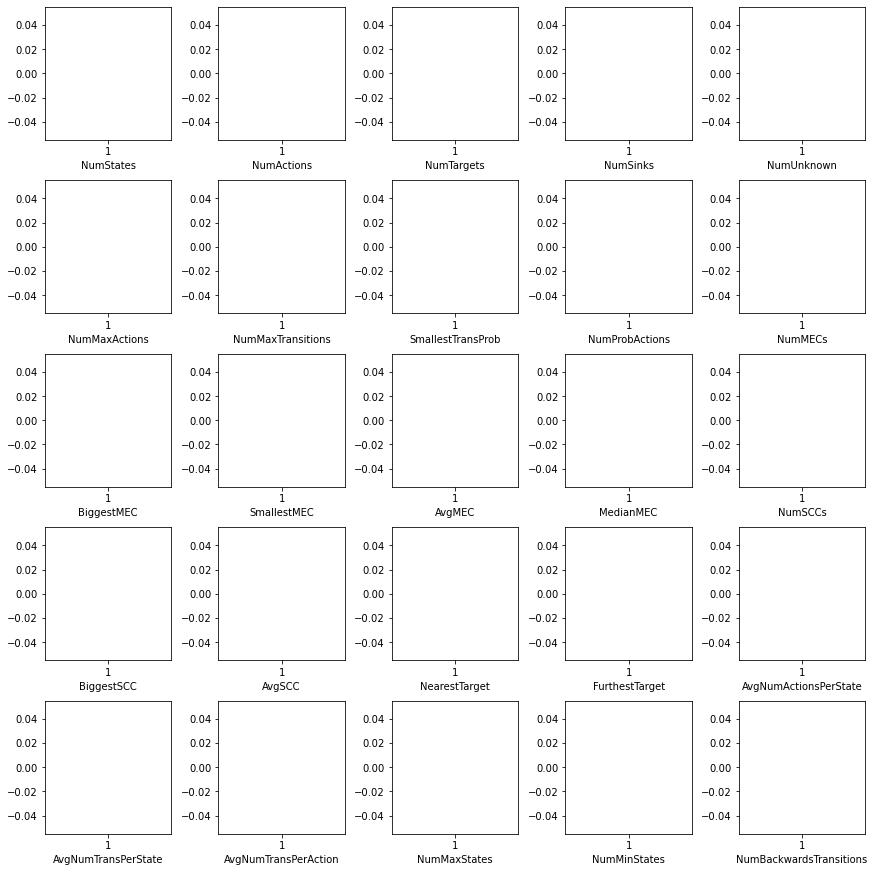

In [22]:
#Make Boxplots

entries_per_column = 5
entries_per_row = int(math.ceil(len(property_keys)/5))
fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
row = 0
column = 0
for property_key in property_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].boxplot(data[property_key], showmeans=True)
        axs[row, column].set_xlabel(property_key)
        column+=1

In [23]:
#Print out specific stuff you are interested in
data_as_np = dict(data)
for key in data_as_np.keys():
    data_as_np[key] = np.asarray(data_as_np[key])
    
#for key in property_keys:    
for key in ["NumStates", "BiggestMEC", "NumMECs", "NumMaxActions", "NumProbActions", "NumUnknown"]:
    print("Key: ", key)
    print("\t Min: ",data_as_np[key].min())
    print("\t Max: ",data_as_np[key].max())
    print("\t Mean: ",data_as_np[key].mean())

Key:  NumStates


ValueError: zero-size array to reduction operation minimum which has no identity


## Look at some graph to gain understanding of dataset

In [ ]:
x_axis = range(len(table_times))
y_axises = dict()

#Init y_axises
for key in config_keys:
    y_axises[key] = data[key]

In [24]:
for config in y_axises.keys():
    plt.plot(x_axis, y_axises[config], label=config)
plt.legend()
plt.show()

NameError: name 'y_axises' is not defined

In [25]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [26]:
# Create Color mapping for confs
colorMapping = dict()

for conf in config_keys:
    if ("BVI" in conf):
        colorMapping[conf] = '#1f77b4'
    elif ("SVI" in conf):
        colorMapping[conf] = '#ff7f0e'
    elif ("OVI" in conf):
        colorMapping[conf] = '#2ca02c'
    elif ("VI" in conf):
        colorMapping[conf] = '#d62728'
    elif ("WP" in conf):
        colorMapping[conf] = '#9467bd'
    elif ("T_SI_SI"):
        colorMapping[conf] = '#8c564b'
    elif ("TOP_BVI"):
        colorMapping[conf] = '#e377c2'
    else:
        colorMapping[conf] = '#7f7f7f'
        
lineStyleMapping = dict()
for conf in config_keys:
    if ("BVI" in conf):
        lineStyleMapping[conf] = 'solid'
    elif ("SVI" in conf):
        lineStyleMapping[conf] = (0, (1, 1)) #'dotted'
    elif ("OVI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) # 'loosely dashed'
    elif ("VI" in conf):
        lineStyleMapping[conf] = (0,(5,1)) #densely dashed
    elif ("SI" in conf):
        lineStyleMapping[conf] = (0, (3, 5, 1, 5, 1, 5)) # 'dashdotted'
    elif ("WP" in conf):
        lineStyleMapping[conf] = 'solid'
        
for conf in config_keys:
    if ("BVI" in conf):
        lineStyleMapping[conf] = (0, (5, 10))
    elif ("SVI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) #'dotted'
    elif ("OVI" in conf):
        lineStyleMapping[conf] = 'solid' #(0, (5, 10)) # 'loosely dashed'
    elif ("VI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) #densely dashed
    elif ("SI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) # 'dashdotted'
    elif ("WP" in conf):
        lineStyleMapping[conf] = (0, (5, 10))
        
markerMapping = dict()
"""
for conf in config_keys:
    if ("D_" in conf):
        markerMapping[conf] = "*" # start
    elif ("T_" in conf):
        markerMapping[conf] = "X" # x (filled)
    elif ("TOP_" in conf):
        markerMapping[conf] = "D" # diamond
    elif ("G_" in conf):
        markerMapping[conf] = "s" # square
    elif ("LP_" in conf):
        markerMapping[conf] = "p" # pentagon
    #elif ("WP" in conf):
        #markerMapping[conf] = "o" # circle
    else:
        markerMapping[conf] = "v" # triangle down
"""

for conf in config_keys:
    if ("BVI" in conf):
        markerMapping[conf] = "*" # start
    elif ("OVI" in conf):
        markerMapping[conf] = "X" # x (filled)
    elif ("SVI" in conf):
        markerMapping[conf] = "D" # diamond
    elif ("VI" in conf):
        markerMapping[conf] = "s" # square
    elif ("WP" in conf):
        markerMapping[conf] = "p" # pentagon
    elif ("TOP_BVI" in conf):
        markerMapping[conf] = "o" # circle
    elif ("T_SI_SI" in conf):
        markerMapping[conf] = "v" # triangle
    else:
        markerMapping[conf] = "."

In [27]:
# Since we want to sort legend by when an algo stops (So e.g. condon first, as it solves only 5), we need this method to find min. 
# for_ordering is a dict that maps each algo to a tuple: (Number of solved benchmarks, time to solve them all)
myDict = dict()
for_ordering = dict()

def my_min(for_ordering):
    min = (math.inf,math.inf) #certainly greater, as only 34 benchmarks
    min_algo = "None"
    for algo in for_ordering.keys():
        bench,time = for_ordering[algo]
        
        if bench < min[0] or (bench == min[0] and time > min[1]):
            min = (bench,time)
            min_algo = algo
    return min_algo

for algo in config_keys:
    subres = [float(i) for i in data[algo] if (i != PENTALY_FOR_NOT_FINISHING)]
    subres.sort()
    myDict[algo] = [i for i in subres]
    if (subres == []):
        print("For Algo %s not one model was solved" % (algo))
    for_ordering[algo] = (len(subres),subres[len(subres)-1])

# Get a list of algos in order for the legend
ordered_algos = []
while bool(for_ordering):
    min_algo = my_min(for_ordering)
    ordered_algos += [min_algo]
    for_ordering.pop(min_algo)


#print(myDict)

fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.set_xlabel("Solved benchmarks")
ax1.set_ylabel("Time")

#fig2, ax2 = plt.subplots()
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Solved benchmarks")


x = range(1,len(data["NumStates"])+1)

#x2 = range(0,1700)

legend_sorting = []
runtimes = dict()
errors = dict()
sorting = dict()
label_mapping = dict()
label_reverse_mapping = dict()

for conf in config_keys:
    label_reverse_mapping[conf] = conf
    label_mapping[conf] = conf
    runtimes[conf] = 0
    errors[conf] = 0
    sorting[conf] = 0
    for i in range(len(data[conf])):
        if (data[conf][i] != PENTALY_FOR_NOT_FINISHING):
            runtimes[conf] += data[conf][i]
            sorting[conf] += data[conf][i]
        else:
            errors[conf] += 1
            sorting[conf] += 15 * 60 * 1000
    legend_sorting.append([conf, sorting[conf]])
legend_sorting.sort(key = lambda x : x[1])

label_mapping["TOP_BVI"] = "PT-BVI"
label_reverse_mapping["PT-BVI"] = "TOP_BVI"
label_mapping["T_SI_SI"] = "T-SI"
label_reverse_mapping["T-SI"] = "T_SI_SI"

for conf in legend_sorting:
    print("Conf %s: \t%f \t Not Finished / Error / Wrong Result: \t %i" % (conf[0], runtimes[conf[0]], errors[conf[0]]))




ordered_algos.reverse()
for algo in ordered_algos:
    y = [sum(myDict[algo][:i+1]) for i in range(0,len(myDict[algo])) if myDict[algo][i] != PENTALY_FOR_NOT_FINISHING]
    ax1.plot([i for i in x if i<=len(myDict[algo])],y,
             c = colorMapping[algo],
             #linestyle = lineStyleMapping[algo],
            )
    ax1.scatter(x[len(myDict[algo])-1],y[len(myDict[algo])-1],
                label=label_mapping[algo],
                c = colorMapping[algo],
                marker=markerMapping[algo], s=50,
               )
    handles, labels = ax1.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: sorting[label_reverse_mapping[t[0]]]))
    #print(labels)
    #print(handles)
    ax1.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
    #plt.legend(loc="upper left")
    """
    if algo == "19":
    ax1.plot([i for i in x if i<=len(myDict[algo])],y, label=algo, c='tab:brown', zorder=1)
    ax1.scatter(x[len(myDict[algo])-1],y[len(myDict[algo])-1], s=30, marker='*', c='tab:brown', zorder=2)
    """

#fig2.savefig('Time2Bench')




For Algo VI not one model was solved


IndexError: list index out of range

In [28]:
# DELETE THIS CELL AFTER TACAS
investigate = "Number Of Verif. Phases"
min_actions = 0#np.array(data[investigate]).min()
max_actions = np.array(data[investigate]).max()
print(min_actions)
print(max_actions)
scatter_coloring = []

for i in range(len(data[investigate])):
    if (data[investigate][i] == 0):
        percent = 1
    else:    
        percent = (data[investigate][i] - min_actions) / (max_actions - min_actions)
        if (data[investigate][i] == 2):
            percent += 0.25
    scatter_coloring.append(percent)
    print(data[investigate][i])
    print(percent)

"""
for i in range(len(data[investigate])):
    percent = (data[investigate][i] - min_actions) / (max_actions - min_actions)
    if (data[investigate][i] >= 3.25 and data[investigate][i] <= 9):
        percent += 0.5#0.1*data[investigate][i]
    scatter_coloring.append(percent)
    print(data[investigate][i])
    print(percent)
"""

KeyError: 'Number Of Verif. Phases'

NameError: name 'scatter_coloring' is not defined

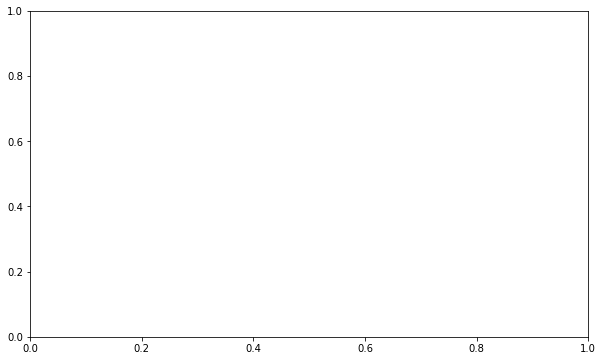

In [29]:
#Use scale that doubles itself (as in OVI paper)
algo_on_x = "OVI"
algo_on_y = "BVI"

#Transform Data
data_for_x = data[algo_on_x].copy()
data_for_y = data[algo_on_y].copy()

axis_limits = [
    10**0 if (not USE_ITERS) else 1,
    950 if (not USE_ITERS) else 10**5
]

ticks = []
ticklabels = []
for i in range(0, 3 if not USE_ITERS else 6):
    ticks.append(10**i)
    ticklabels.append(str(10**i)+"s")
#ticks.append(100)
ticks = [1, 10, 100, 950]
ticklabels = [1, 10, 100, 950]
ticklabels[-1] = ("Timeout / Error")

for i in range(len(data_for_x)):
    if (data_for_x[i] > axis_limits[1]):
        data_for_x[i] = axis_limits[1]
    #if (data_for_x[i] < axis_limits[0]):
    #    data_for_x[i] = axis_limits[0]

for i in range(len(data_for_y)):
    if (data_for_y[i] > axis_limits[1]):
        data_for_y[i] = axis_limits[1]
    #if (data_for_y[i] < axis_limits[0]):
    #    data_for_y[i] = axis_limits[0]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data_for_x, data_for_y, c = scatter_coloring, cmap=plt.get_cmap("viridis"), alpha = 0.75)

label_prios = dict()
label_prios[">=8 / Timeout"] = 1
label_prios["2 - 7"] = 2
label_prios["1"] = 3

ax.scatter([0.1], [0.1], c = ["#d0e023"], label=">=8 / Timeout")
ax.scatter([0.1], [0.1], c = ["#299086"], label="2 - 7")
ax.scatter([0.1], [0.1], c = ["#451d6c"], label="1")


ax.plot(axis_limits, axis_limits, 'k-', alpha=0.75, zorder=0)
ax.plot(list(map(lambda x : x * 2, axis_limits)), axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
ax.plot(list(map(lambda x : x / 2, axis_limits)), axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
ax.set_aspect('equal')
ax.set_xlabel(label_mapping[algo_on_x])
ax.set_ylabel(label_mapping[algo_on_y])
ax.set_xlim(axis_limits)
ax.set_ylim(axis_limits)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: label_prios[t[0]]))
#print(labels)
#print(handles)
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

#### Vanilla vs Optim Scatters

No handles with labels found to put in legend.


T_BVI not in Data - have you included it in the notebook and in the benchmarks?
T_OVI not in Data - have you included it in the notebook and in the benchmarks?


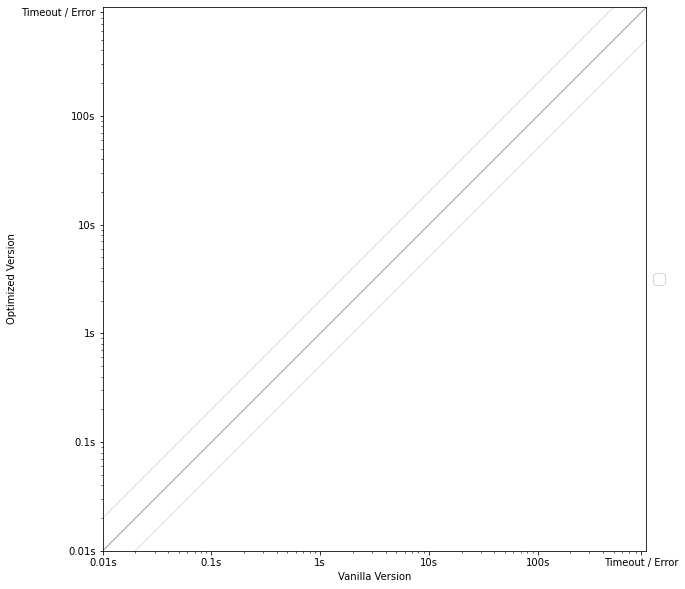

In [30]:
base_algos = ["BVI", "OVI"]
extensions = [
    #"D", 
    #"G", 
    #"TOP", 
    "T", 
    #"OPT"
]
axis_limits = [
    10**-2 if (not USE_ITERS) else 1,
    10**3 if (not USE_ITERS) else 10**5
]

ticks = []
ticklabels = []
for i in range(-2, 3 if not USE_ITERS else 6):
    ticks.append(10**i)
    ticklabels.append(str(10**i)+"s")
ticks.append(PENTALY_FOR_NOT_FINISHING)
ticklabels.append("Timeout / Error")
#ticklabels[-1] = "Timeout / Error"

algo_to_marker = dict()
algo_to_marker["BVI"] = "X"
algo_to_marker["SVI"] = "^"
algo_to_marker["OVI"] = "s"

market_to_size = dict()



for extension in extensions:
    fig, ax = plt.subplots(figsize=(10,10))
    for base_algo in base_algos:
        optim_algo = extension+"_"+base_algo
        if (optim_algo not in data):
            print("%s not in Data - have you included it in the notebook and in the benchmarks?" % optim_algo)
            continue

        data_for_x = data[base_algo].copy()
        data_for_y = data[optim_algo].copy()

        for i in range(len(data_for_x)):
            if (data_for_x[i] > axis_limits[1]):
                data_for_x[i] = axis_limits[1]

        for i in range(len(data_for_y)):
            if (data_for_y[i] > axis_limits[1]):
                data_for_y[i] = axis_limits[1]

        ax.scatter(data_for_x, data_for_y, label=("%s / %s" % (base_algo, optim_algo)), alpha = 0.7, marker=algo_to_marker[base_algo])

    
    ax.plot(axis_limits, axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x * 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x / 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("Vanilla Version")
    ax.set_ylabel("Optimized Version")
    
    ax.set_xlim(axis_limits)
    ax.set_ylim(axis_limits) 
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)


#### One Algorithm against others

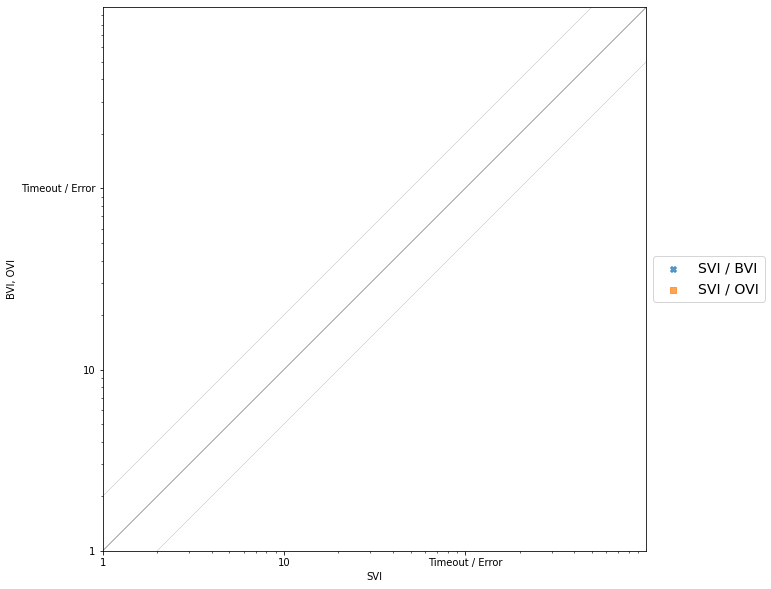

In [31]:
bottom_algos = ["SVI"]
against_algos = ["BVI", "OVI"]

axis_limits = [
    10**0 if (not USE_ITERS) else 1,
    10**3 if (not USE_ITERS) else 10**5
]

ticks = []
ticklabels = []
for i in range(0, 3 if not USE_ITERS else 6):
    ticks.append(10**i)
    ticklabels.append(str(10**i)+"")
#ticks.append(PENTALY_FOR_NOT_FINISHING)
#ticklabels.append("Timeout / Error")
ticklabels[-1] = "Timeout / Error"

algo_to_marker = dict()
algo_to_marker["BVI"] = "X"
algo_to_marker["SVI"] = "^"
algo_to_marker["OVI"] = "s"
algo_to_marker["T_LP_SI"] = "X"
algo_to_marker["T_SI_SI"] = "^"

market_to_size = dict()

def list_to_string(l):
    x = ""
    for i in l:
        x+=str(i)+", "
    x = x[0:-2]
    return x

for bottom_algo in bottom_algos:
    fig, ax = plt.subplots(figsize=(10,10))
    for against_algo in against_algos:
        if (against_algo not in data):
            print("%s is not in Data? " % against_algo)
        if (bottom_algo not in data):
            print("%s is not in Data? " % bottom_algo)

        data_for_x = data[bottom_algo].copy()
        data_for_y = data[against_algo].copy()

        for i in range(len(data_for_x)):
            if (data_for_x[i] > axis_limits[1]):
                data_for_x[i] = axis_limits[1]

        for i in range(len(data_for_y)):
            if (data_for_y[i] > axis_limits[1]):
                data_for_y[i] = axis_limits[1]

        ax.scatter(data_for_x, data_for_y, label=("%s / %s" % (bottom_algo, against_algo)), alpha = 0.7, marker=algo_to_marker[against_algo])

    ax.plot(axis_limits, axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x * 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x / 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.set_aspect('equal')
    ax.set_xlabel(bottom_algo)
    ax.set_ylabel(list_to_string(against_algos))
    
    ax.set_xlim(axis_limits)
    ax.set_ylim(axis_limits) 
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

# Tell me more about the models where ...

In [32]:
#DELETE THIS CELL AFTER TACAS
random_model_indices = []
non_random_model_indices = []
for i in range(len(data['NumStates'])):
    model = model_names[i]
    
    if ("RANDOM" in model):
        random_model_indices.append(i)
    else:
        non_random_model_indices.append(i)
        
print(non_random_model_indices)
print(list(map(lambda x : model_names[x], non_random_model_indices)))

[]
[]


In [33]:
# Define comparation functions
def compare_two_confs(conf_a, conf_b, remove_where_function_is_true):
    model_indices = []
    for i in range(len(data['NumStates'])):
        model = model_names[i]

        model_is_interesting = True
        for f in remove_where_function_is_true:
            if (f(data[conf_a][i], data[conf_b][i])):
                model_is_interesting = False
                break 
        if not model_is_interesting:
            continue
        
        model_indices.append(i)
    return model_indices 

In [34]:
# Define evaluation
def evaluate_conf_comparison(conf_a, conf_b, filtered_indices, interesting_props):
    for index in filtered_indices:
        model_name = model_names[index]
        print("Model: %s" % model_name)
        print("%s: %f" % (conf_a, data[conf_a][index]))
        print("%s: %f" % (conf_b, data[conf_b][index]))

        for prop_key in interesting_props:
            print("%s: %f" % (prop_key, data[prop_key][index]))

In [35]:
# Define filters
remove_where = [
    lambda x,y : y >= 5 * x
]

In [36]:
interesting_props = [
    "NumMaxActions",
    "AvgNumActionsPerState"
]
interesting_props = property_keys


exclude_props = [
    "NumSinks",
    "NumTargets",
    
]

In [37]:
# Get Results
conf_a = "T_LP_SI"
conf_b = "LP_SI"
event_a = compare_two_confs(conf_a, conf_b, [lambda x,y : x < 5 * y])
counter_event_a = compare_two_confs(conf_a, conf_b, [lambda x,y : y >= 5 * x])
mirror_event_a = compare_two_confs(conf_a, conf_b, [lambda x,y : y < 5 * x])
print(len(event_a))
print(len(mirror_event_a))
print(len(counter_event_a))
evaluate_conf_comparison(conf_a, conf_b, event_a, [])

#interesting_props = ["BiggestSCC", "BiggestMEC"]
evaluate_conf_comparison(conf_a, conf_b, event_a, interesting_props)
print(interesting_props)


0
0
0
['NumStates', 'NumActions', 'NumTargets', 'NumSinks', 'NumUnknown', 'NumMaxActions', 'NumMaxTransitions', 'SmallestTransProb', 'NumProbActions', 'NumMECs', 'BiggestMEC', 'SmallestMEC', 'AvgMEC', 'MedianMEC', 'NumSCCs', 'BiggestSCC', 'AvgSCC', 'NearestTarget', 'FurthestTarget', 'AvgNumActionsPerState', 'AvgNumTransPerState', 'AvgNumTransPerAction', 'NumMaxStates', 'NumMinStates', 'NumBackwardsTransitions']


In [38]:
def oneDimensionPropertyScatterPlot(property_keys, a_indices, b_indices):
    entries_per_column = 1
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,20), constrained_layout = True)
    row = 0
    column = 0
    
    for property_key in property_keys:
        data_for_a = []
        data_for_b = []
        for i in a_indices:
            data_for_a.append(data[property_key][i])
        for i in b_indices:
            data_for_b.append(data[property_key][i])
            
        ALPHA_A = 10/len(data_for_a)
        #ALPHA_A = 0.5
        
        
        ALPHA_B = 3/len(data_for_b)
        #ALPHA_B = 0.5
        
        axs[row].scatter(data_for_a, [1]*len(data_for_a), alpha=ALPHA_A, c='red')
        axs[row].scatter(data_for_b, [-1]*len(data_for_b), alpha=ALPHA_B, c='green')
        axs[row].scatter([data_for_a[0], data_for_a[0]], [-3, 3], alpha=0.001) # Set Axis limits
        axs[row].set_xlabel(property_key)
        row+=1

RED: RANDOM, GREEN: REAL
['NumStates', 'NumActions', 'NumTargets', 'NumSinks', 'NumUnknown', 'NumMaxActions', 'NumMaxTransitions', 'SmallestTransProb', 'NumProbActions', 'NumMECs', 'BiggestMEC', 'SmallestMEC', 'AvgMEC', 'MedianMEC', 'NumSCCs', 'BiggestSCC', 'AvgSCC', 'NearestTarget', 'FurthestTarget', 'AvgNumActionsPerState', 'AvgNumTransPerState', 'AvgNumTransPerAction', 'NumMaxStates', 'NumMinStates', 'NumBackwardsTransitions']


ZeroDivisionError: division by zero

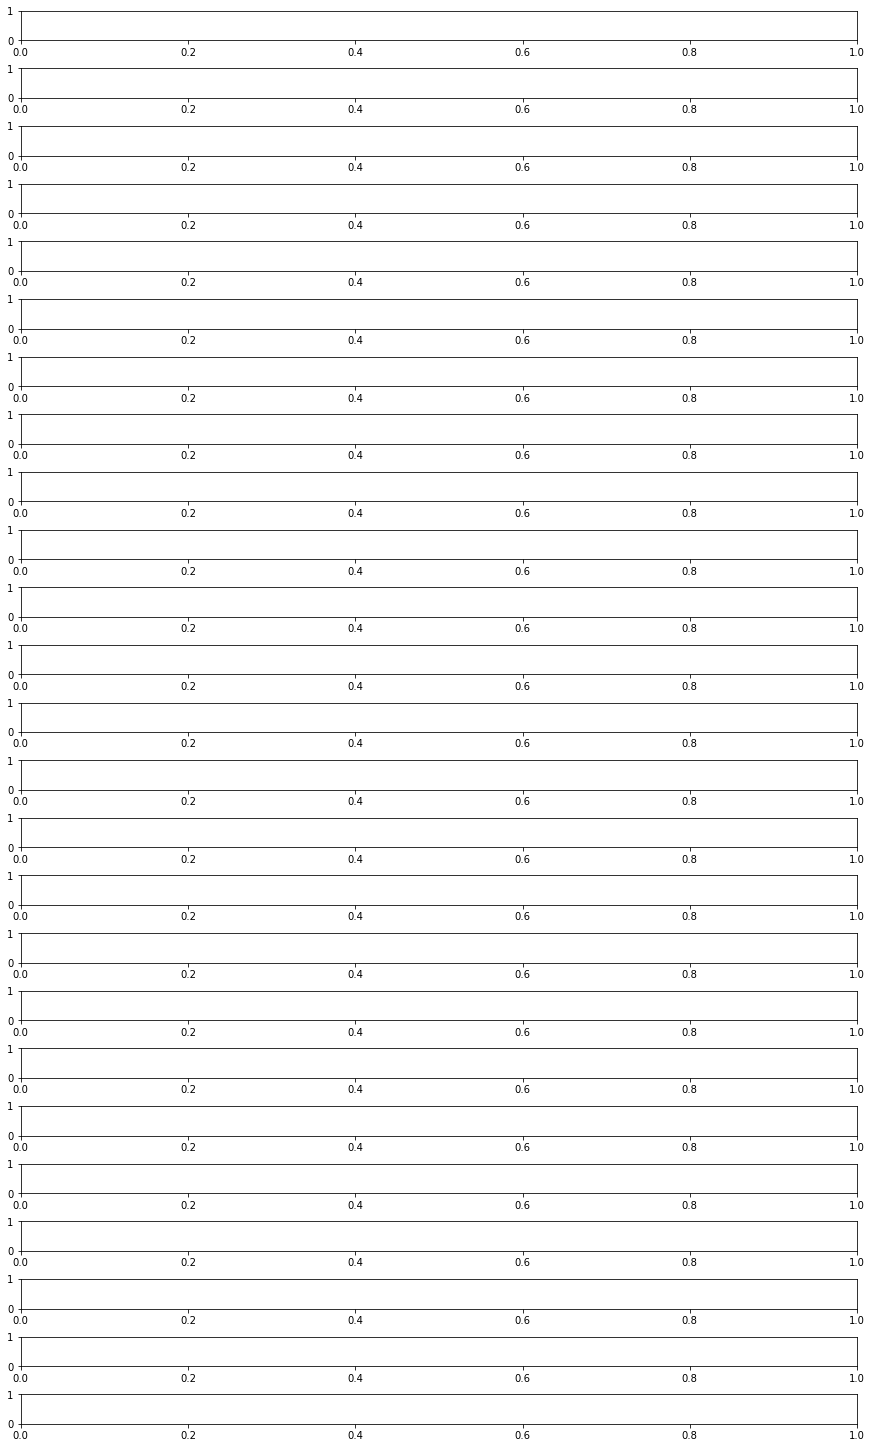

In [39]:
#print("RED: %s" % conf_a)
#print("GREEN: %s" % conf_b)
print("RED: RANDOM, GREEN: REAL")
print(interesting_props)


oneDimensionPropertyScatterPlot(interesting_props, random_model_indices, non_random_model_indices)

### Interpret the graph

In [ ]:
print(len(model_names))
print(len(data["NumStates"]))

In [ ]:
#Get names of models above certain threshold

absolute_allowed_timedifference_in_seconds = 2
relative_allowed_timedifference = 0.1 # 0.1 -> 10% allowed difference
USE_RELATIVE_ERROR = True

confs_to_compare = config_keys
#confs_to_compare = ["OVI_1", "OVI_100"]

fastest_solver = dict()
for index in range(len(data["NumStates"])):
    model = model_names[index]
    print("MODEL: %s" % model)
    fastest_solver[model] = [10000000, []]
    for key in confs_to_compare:
        soln_time = data[key][index]
        print("Conf %s soln time %f" % (key, soln_time))
        if (soln_time != PENTALY_FOR_NOT_FINISHING):
            #print("This is better than NOT FINISHING")
            if (fastest_solver[model][0] > soln_time):
                # Check which of the currently saved models are in the allowed precision
                new_soln_time = fastest_solver[model][0]
                fastest_solvers_for_model = [key]
                for old_key in fastest_solver[model][1]:
                    old_soln_time = data[old_key][index]
                    # Do comparison
                    include_old_key = False
                    
                    USE_RELATIVE_ERROR = new_soln_time > 10
                    
                    if (USE_RELATIVE_ERROR):
                        include_old_key = (1.0 - relative_allowed_timedifference) * new_soln_time <= old_soln_time
                    else:
                        include_old_key = abs(new_soln_time - old_soln_time) <= absolute_allowed_timedifference_in_seconds
                    
                    if (include_old_key):
                        fastest_solvers_for_model.append(old_key)
                
                fastest_solver[model] = [soln_time, fastest_solvers_for_model]
                
            elif (fastest_solver[model][0] == soln_time):
                fastest_solver[model][1].append(key)

In [ ]:
bestSolvers = dict()
for config_key in confs_to_compare:
    bestSolvers[config_key] = 0

for index in range(len(data["NumStates"])):
    model_name = model_names[index]
    for config_key in fastest_solver[model_name][1]:
        bestSolvers[config_key]+=1

for config_key in confs_to_compare:
    print("Config %s was the best solution method %d / %d times" % (config_key, bestSolvers[config_key], len(table_times)))

In [ ]:
#If you want to know which Models a Conf won, use this:
check_conf = "TBBVI_100"
explicit = True

for index in range(len(data["NumStates"])):
    model = model_names[index]
    if check_conf in fastest_solver[model][1]:
        print(model)
        if explicit:
            props = findModelWithNameInTable(table_properties, model)
            #print(props["NumSCCs"])
            for prop in props:
                print(prop," : ", props[prop])

# Do classic Data Mining stuff

## Heatmaps

In [ ]:
excluded_features = [
    #"NumTargets",
    #"SmallestTransProb"
]

correlation_dict = dict(data)

for feature in excluded_features:
    del correlation_dict[feature]

size = len(analysis_keys) - len(excluded_features) + len(config_keys)
print(size)

In [ ]:
#Linear Correlation
fig = plt.figure(figsize=(size,size))

df = pd.DataFrame(correlation_dict,columns=correlation_dict.keys())

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


## Scatter Plots

In [ ]:
#Scatterplot
def createScatterPlotForOneProperty(property_key):
    entries_per_column = int(math.sqrt(len(config_keys))+1)
    entries_per_row = entries_per_column
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(16,16), sharey=True)
    row = 0
    column = 0
    for key in config_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].scatter(data[property_key], data[key])
        axs[row, column].set_xlabel(property_key),
        axs[row, column].set_ylabel(key)
        column+=1

def createScatterPlotForOneConfig(property_keys):
    entries_per_column = 1    
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            axs[row].scatter(data[property_key], data[key])
            axs[row].set_xlabel(property_key),
            axs[row].set_ylabel(key)
            column+=1

def createScatterPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,20), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            if (USE_LABELS):
                axs[row, column].scatter(data[property_key], data[key], alpha=0.5, c=pandas_labels.map(coloring))
            else:
                axs[row, column].scatter(data[property_key], data[key], alpha=0.2)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

def createHistPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            sn.histplot(x = data[property_key], y =  data[config_key], cbar=True)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

In [ ]:
if(USE_LABELS):
    print(coloring)

createScatterPlotForMultipleProperties(
    [
        #"NumStates",
        #"NumTargets",
        #"NumSinks",
        #"NumUnknown",
        "NumActions",
        "NumMaxActions",
        "NumMaxTransitions",
        "SmallestTransProb",
        "NumProbActions",
        "NumMECs",
        "BiggestMEC",
        #"SmallestMEC",
        #"AvgMEC",
        #"MedianMEC",
        "NumSCCs",
        "BiggestSCC",
        #"AvgSCC",
        "NearestTarget",
        #"FurthestTarget"
    ]
)

In [ ]:
#createHistPlotForMultipleProperties(["BiggestMEC", "NumUnknown", "NumMECs", "NumStates", "NumMaxActions", "NumProbActions"])

## Chi-square Tests: Are two features independent?

In [ ]:
def bin_estimate(length):
    return int(1+math.log2(length))

In [ ]:
#Histograms
#Each Bin should contain at least (recommended) 13 entries
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
prop = "NumUnknown"

x_set = [1]*37 + [2]*13 + [3]*13
y_set = [100]*37 + [300]*13 + [500]*13
print(x_set)
x_bins = (1, 2, 3, 4)#bin_estimate(len(data_set))
y_bins = (100, 300, 500, 700)

x_hist_gram = np.histogram(x_set, bins=x_bins)
y_hist_gram = np.histogram(y_set, bins=(100, 200, 300))
n, bins, patches = plt.hist(x=x_set, bins=x_bins, alpha = 0.7)
plt.xlabel('Computation Times')
plt.ylabel('Frequency')

plt.show()


In [ ]:

H, xedges, yedges = np.histogram2d(x_set, y_set, bins=(x_bins, y_bins))
print(H)
# Histogram does not follow Cartesian convention (see Notes),

# therefore transpose H for visualization purposes.

H = H.T
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(131, title='imshow: square bins')

plt.imshow(H, interpolation='nearest', origin='lower')

In [ ]:
# create data
x = [0]*5000#np.random.normal(size=5000)
y = [1]*5000#np.random.normal(size=5000)
 
# Big bins
H, x_edges, y_edges, img = plt.hist2d(x, y, bins=(10,10), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# Small bins
#plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.jet)
#plt.show()
 
# If you do not set the same values for X and Y, the bins won't be a square!
#plt.hist2d(x, y, bins=(300, 30), cmap=plt.cm.jet)
#plt.show()

In [ ]:
#print(H)
ChiSq, p = stats.chisquare(np.ndarray.flatten(H))
print(ChiSq)
print(p)

#### Ensure VI is not wrong

In [ ]:
vi = "VI"
ref = "BVI"

for i in range(len(data[vi])):
    